#  Housing Price Index -- Time Series Analysis
- Date:  12/10/2024
- Author:  Bill Louer
- Datasource:  https://www.fhfa.gov/data/hpi/datasets

<img src='https://www.fhfa.gov/themes/custom/fhfa_subtheme/fhfa-logo.png' alt="Generic Image" width="200" height="50" >
Logo from Federal Housing Authority

##  Table of Contents
1.  [Project Overview](#section-1) 
2.  [Data Input](#section-2)
3.  [Data Cleaning](#section-3)
4.  [Exploratory Data Analysis](#section-4)
5.  [Stationarity and Tranformations](#section-5)
6.  [Modeling and Evaluation](#section-6)
7.  [Findings and Conclusions](#section-7)

##  1. Project Overview <a class="anchor" id="section-1"></a>

###  Objectives:  
-  Import the Housing Price Index data and clean the dataset.  
-  Review the Housing Price Indices from FHA and evaluate the trends across the regions.
    - NJ and Metro Areas
-  Decompose the series into trend, seasonality and residuals
-  Evaluate autocorrelation and partial autocorrelation
-  Create a forecast using double exponential smoothing and triple exponential smoothing
-  Create a forecast using ARIMA and SARIMA models
-  Select the best forecast based on MAE, RSME and forecast forward 8-12 quarters.

#### Dataset source:  https://www.fhfa.gov/data/hpi/datasets
##### Data Contents:
- The dataset comprises 

In [1]:
#  import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import scipy.stats as stats

#  Statistical test to measure stationarity
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, quarter_plot
from scipy.stats import boxcox

#  Modeling and Forecasting Tools
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set pandas display precision for floats
pd.set_option('display.precision', 2)  # Set to 2 decimal places

In [3]:
#  Setting up the plot format.

plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

## 2. Data Input <a class="anchor" id="section-2"></a>

In [4]:
df_hpi = pd.read_csv('../data/raw/hpi_master.csv')
df_hpi.head()

,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa
0,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,1,100.00,100.00
1,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,2,100.89,100.94
2,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,3,101.30,100.90
3,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,4,101.68,100.96
4,traditional,purchase-only,monthly,USA or Census Division,East North Central Division,DV_ENC,1991,5,102.30,101.32


## 3.  Data Cleaning <a class="anchor" id="section-3"></a>

In [5]:
#  Find out what unique categorical data is in each column
cat_columns = df_hpi.select_dtypes(include=['object', 'category']).columns
for col in cat_columns:
    print('---------------','\n',df_hpi.value_counts(col))

--------------- 
 hpi_type
traditional      119863
non-metro          5593
distress-free      1620
developmental       233
Name: count, dtype: int64
--------------- 
 hpi_flavor
all-transactions    84804
purchase-only       27520
expanded-data       14985
Name: count, dtype: int64
--------------- 
 frequency
quarterly    123259
monthly        4050
Name: count, dtype: int64
--------------- 
 level
MSA                       88824
State                     29512
USA or Census Division     8740
Puerto Rico                 233
Name: count, dtype: int64
--------------- 
 place_name
West North Central Division      874
United States                    874
South Atlantic Division          874
Mountain Division                874
West South Central Division      874
                                ... 
Johnstown, PA                    119
Beckley, WV                      111
California-Lexington Park, MD    108
Hinesville, GA                    99
The Villages, FL                  96
Name: coun

In [6]:
df_hpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127309 entries, 0 to 127308
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   hpi_type    127309 non-null  object 
 1   hpi_flavor  127309 non-null  object 
 2   frequency   127309 non-null  object 
 3   level       127309 non-null  object 
 4   place_name  127309 non-null  object 
 5   place_id    127309 non-null  object 
 6   yr          127309 non-null  int64  
 7   period      127309 non-null  int64  
 8   index_nsa   127308 non-null  float64
 9   index_sa    42505 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 9.7+ MB


In [7]:
#  Screen the data to include the regions of interest
filter = (df_hpi.place_name.str.contains(('NJ'))) & (df_hpi.hpi_type == 'traditional') & (df_hpi.frequency == 'quarterly') \
    & (df_hpi.hpi_flavor == 'all-transactions')
df_nj = df_hpi[filter]
df_nj

,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa
5224,traditional,all-transactions,quarterly,MSA,"Allentown-Bethlehem-Easton, PA-NJ",10900,1978,2,41.68,NaN
5225,traditional,all-transactions,quarterly,MSA,"Allentown-Bethlehem-Easton, PA-NJ",10900,1978,3,46.86,NaN
5226,traditional,all-transactions,quarterly,MSA,"Allentown-Bethlehem-Easton, PA-NJ",10900,1978,4,47.04,NaN
5227,traditional,all-transactions,quarterly,MSA,"Allentown-Bethlehem-Easton, PA-NJ",10900,1979,1,46.79,NaN
5228,traditional,all-transactions,quarterly,MSA,"Allentown-Bethlehem-Easton, PA-NJ",10900,1979,2,45.35,NaN
...,...,...,...,...,...,...,...,...,...,...
69557,traditional,all-transactions,quarterly,MSA,"Wilmington, DE-MD-NJ (MSAD)",48864,2023,3,296.41,NaN
69558,traditional,all-transactions,quarterly,MSA,"Wilmington, DE-MD-NJ (MSAD)",48864,2023,4,297.46,NaN
69559,traditional,all-transactions,quarterly,MSA,"Wilmington, DE-MD-NJ (MSAD)",48864,2024,1,302.57,NaN
69560,traditional,all-transactions,quarterly,MSA,"Wilmington, DE-MD-NJ (MSAD)",48864,2024,2,310.88,NaN


In [8]:
#  convert the year and quarter to a datetime column
# Combine 'Year' and 'Quarter' to create a datetime column
df_nj.loc[:,'Qtr_ending'] = pd.PeriodIndex(df_nj['yr'].astype(str) + 'Q' + df_nj['period'].astype(str), freq='Q').end_time.normalize()
df_nj

,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,Qtr_ending
5224,traditional,all-transactions,quarterly,MSA,"Allentown-Bethlehem-Easton, PA-NJ",10900,1978,2,41.68,NaN,1978-06-30
5225,traditional,all-transactions,quarterly,MSA,"Allentown-Bethlehem-Easton, PA-NJ",10900,1978,3,46.86,NaN,1978-09-30
5226,traditional,all-transactions,quarterly,MSA,"Allentown-Bethlehem-Easton, PA-NJ",10900,1978,4,47.04,NaN,1978-12-31
5227,traditional,all-transactions,quarterly,MSA,"Allentown-Bethlehem-Easton, PA-NJ",10900,1979,1,46.79,NaN,1979-03-31
5228,traditional,all-transactions,quarterly,MSA,"Allentown-Bethlehem-Easton, PA-NJ",10900,1979,2,45.35,NaN,1979-06-30
...,...,...,...,...,...,...,...,...,...,...,...
69557,traditional,all-transactions,quarterly,MSA,"Wilmington, DE-MD-NJ (MSAD)",48864,2023,3,296.41,NaN,2023-09-30
69558,traditional,all-transactions,quarterly,MSA,"Wilmington, DE-MD-NJ (MSAD)",48864,2023,4,297.46,NaN,2023-12-31
69559,traditional,all-transactions,quarterly,MSA,"Wilmington, DE-MD-NJ (MSAD)",48864,2024,1,302.57,NaN,2024-03-31
69560,traditional,all-transactions,quarterly,MSA,"Wilmington, DE-MD-NJ (MSAD)",48864,2024,2,310.88,NaN,2024-06-30


In [9]:
df_reindexed = df_nj.set_index('Qtr_ending')
df_pivot = df_reindexed.pivot(columns=['place_name'], values='index_nsa')
df_pivot.tail()

place_name,"Allentown-Bethlehem-Easton, PA-NJ","Atlantic City-Hammonton, NJ","Camden, NJ (MSAD)","New Brunswick-Lakewood, NJ (MSAD)","New York-Jersey City-White Plains, NY-NJ (MSAD)","Newark, NJ-PA (MSAD)","Ocean City, NJ","Trenton-Princeton, NJ","Vineland-Bridgeton, NJ","Wilmington, DE-MD-NJ (MSAD)"
Qtr_ending,,,,,,,,,,
2023-09-30,294.92,355.73,316.37,384.39,378.88,338.13,502.51,317.10,285.84,296.41
2023-12-31,294.57,357.45,321.95,392.62,384.60,342.17,547.16,322.03,293.49,297.46
2024-03-31,304.67,376.79,325.55,398.66,387.48,348.40,547.33,331.53,288.95,302.57
2024-06-30,309.96,374.71,336.52,412.45,404.12,362.75,559.84,335.86,305.80,310.88
2024-09-30,311.14,387.36,345.48,416.45,411.24,366.83,543.84,345.40,311.47,316.62


In [10]:
#  confirm the datetime index covers the full date range
date_range = pd.date_range(start=df_pivot.index.min(), end=df_pivot.index.max(), freq='QE')
df_pivot_reindex = df_pivot.reindex(date_range)

In [11]:
last_na_row = df_pivot_reindex[df_pivot_reindex.isna().any(axis=1)].index.max()
df = df_pivot_reindex.loc[last_na_row:,:]

In [12]:
#  save preliminary cleaned data to a new csv file
df.to_csv('../data/interim/nj_hpi_areas.csv', index=True)

## 4. Exploratory Data Analysis <a class="anchor" id="section-4"></a>

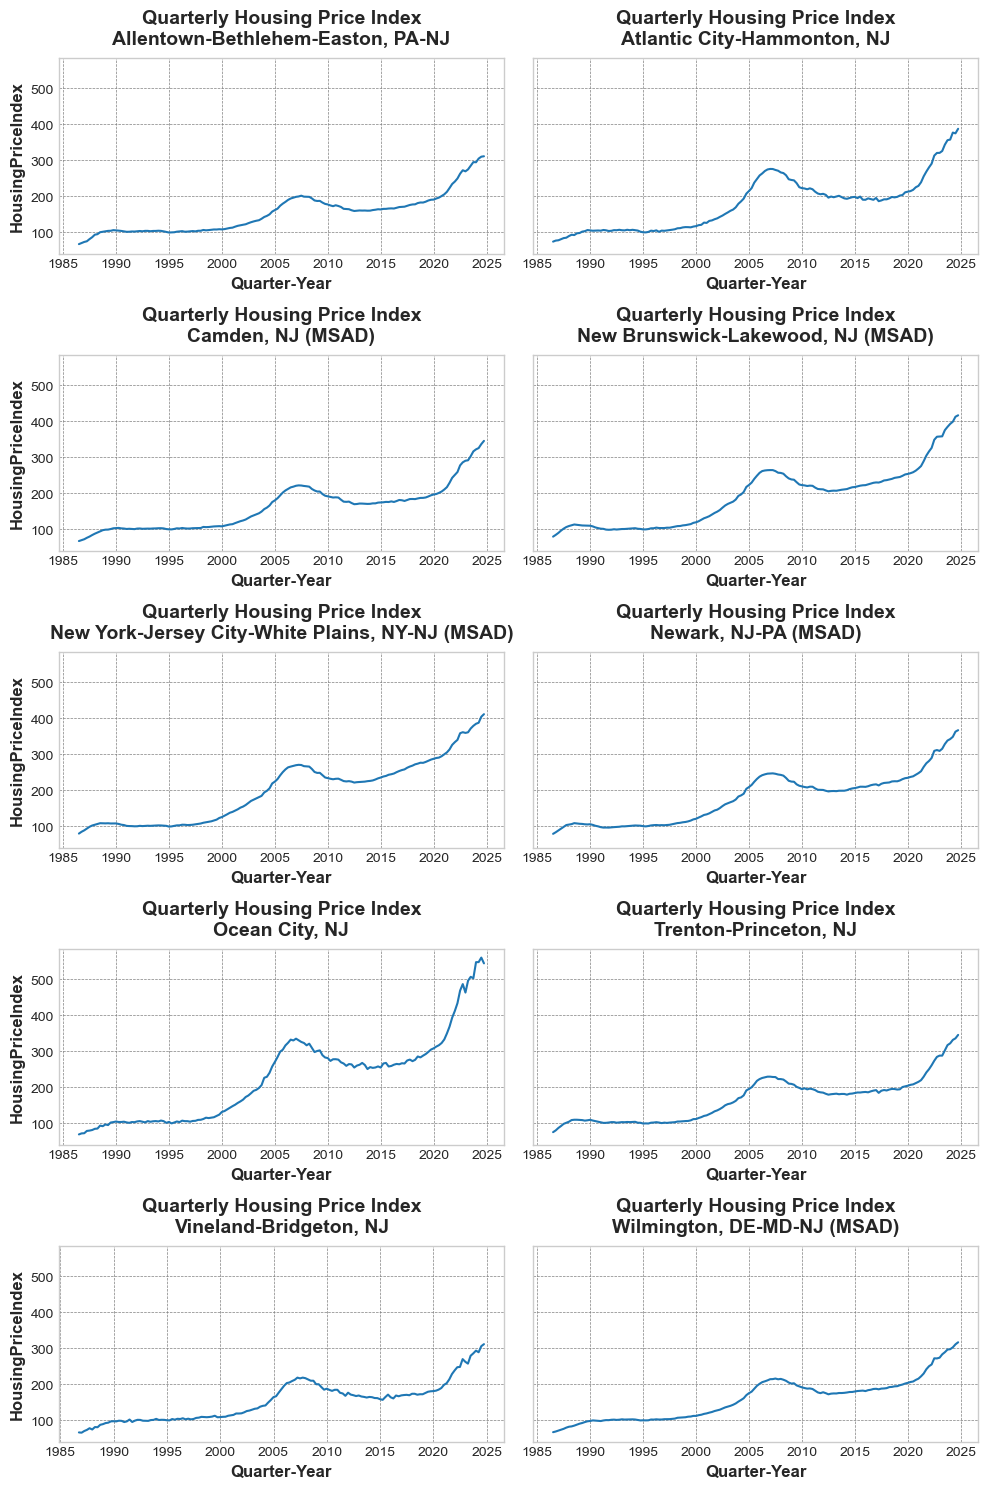

In [13]:
fig, axs = plt.subplots(5, 2, figsize=(10, 15), sharey=True)
axs = axs.flatten()
for i, col in enumerate(df.columns):
    sns.lineplot(x=df.index, y=df[col], ax=axs[i])
    axs[i].set_title(f'Quarterly Housing Price Index\n{col}')
    axs[i].grid(True, which="major", linestyle="--", linewidth=0.5, color="gray")
    axs[i].set_ylabel('HousingPriceIndex')
    axs[i].set_xlabel('Quarter-Year')
plt.tight_layout()
plt.show()

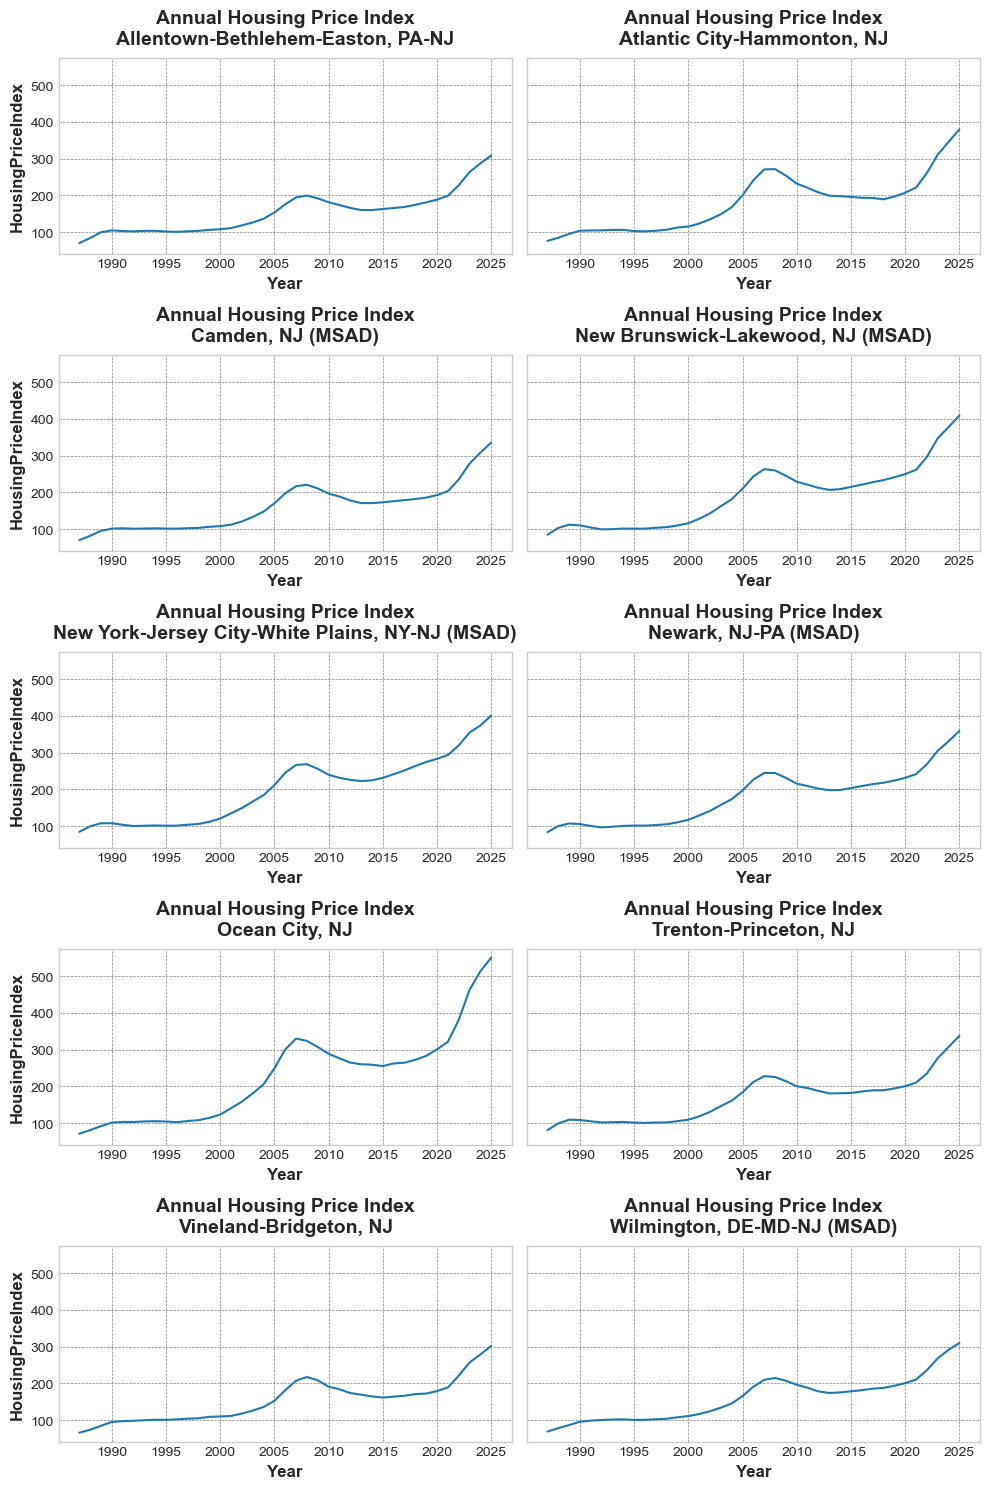

In [14]:
#  reindex by year and plot the annual indices
df_yr = df.resample('YE').mean()
fig, axs = plt.subplots(5, 2, figsize=(10, 15), sharey=True)
axs = axs.flatten()
for i, col in enumerate(df_yr.columns):
    sns.lineplot(x=df_yr.index, y=df_yr[col], ax=axs[i])
    axs[i].set_title(f'Annual Housing Price Index\n{col}')
    axs[i].grid(True, which="major", linestyle="--", linewidth=0.5, color="gray")
    axs[i].set_ylabel('HousingPriceIndex')
    axs[i].set_xlabel('Year')
plt.tight_layout() 
plt.show()

## 5. Stationarity and Transformations <a class="anchor" id="section-5"></a>

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def evaluate_stationarity(series, window=12, lags=20, transformation='none'):
    if transformation == 'diff':
        series = series.diff()
    elif transformation == 'diff2':
        series = series.diff().diff()
    elif transformation == 'log':
        series = np.log(series)
    elif transformation =='log_diff':
        series = (np.log(series)).diff()
    elif transformation =='log_diff2':
        series = (np.log(series)).diff().diff()
    else:
        pass

    # Create a figure
    fig = plt.figure(figsize=(10, 8))
    
    # Define a 3x2 GridSpec
    gs = GridSpec(3, 2, figure=fig)
    
    # Add plots to the grid
    ax1 = fig.add_subplot(gs[0, 0])  # Row 0, Column 0
    ax2 = fig.add_subplot(gs[0, 1])  # Row 0, Column 1
    ax3 = fig.add_subplot(gs[1, 0])  # Row 1, Column 0
    ax4 = fig.add_subplot(gs[1, 1])  # Row 1, Column 1
    ax5 = fig.add_subplot(gs[2, :])  # Row 2, span both columns
    # Time series plot
    ax1.plot(series, label='Time Series')
    ax1.set_title('Time Series')
    ax1.legend()

    # Histogram
    ax2.hist(series, bins=20, edgecolor='k')
    ax2.set_title('Histogram')

    # ACF plot
    plot_acf(series.dropna(), ax=ax3, lags=lags)
    ax3.set_title('Autocorrelation (ACF)')

    # PACF plot
    plot_pacf(series.dropna(), ax=ax4, lags=lags, method='ywm')
    ax4.set_title('Partial Autocorrelation (PACF)')

    # Rolling statistics (span both columns in the third row)
    ax_rolling = ax5  # Select all columns in the last row
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    ax_rolling.plot(series, label='Original')
    ax_rolling.plot(rolling_mean, label='Rolling Mean')
    ax_rolling.plot(rolling_std, label='Rolling Std', linestyle='--')
    ax_rolling.set_title('Rolling Statistics')
    ax_rolling.legend()
    
    # # Remove unused axes in the 3rd row (right column)
    # fig.delaxes(axes[2, 1])

    # Adjust layout for better appearance
    plt.tight_layout()
    plt.show()

    # ADF test
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")


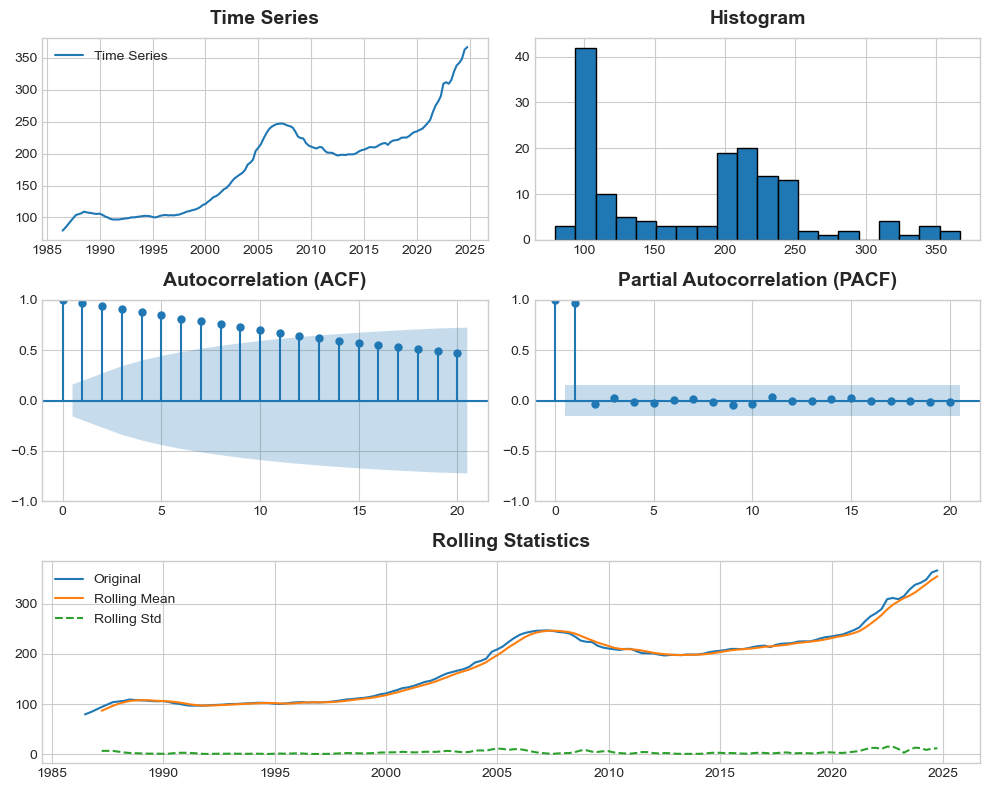

ADF Statistic: 0.3485172652525984
p-value: 0.9794641538451463
Critical Values: {'1%': np.float64(-3.4750180242954167), '5%': np.float64(-2.8811408028842043), '10%': np.float64(-2.577221358046935)}
The series is non-stationary.


In [16]:
#  pick one column and test stationarity, and transformation
df_ewr = df.iloc[:, 5]
evaluate_stationarity(df_ewr, window=4, lags=20, transformation='none')

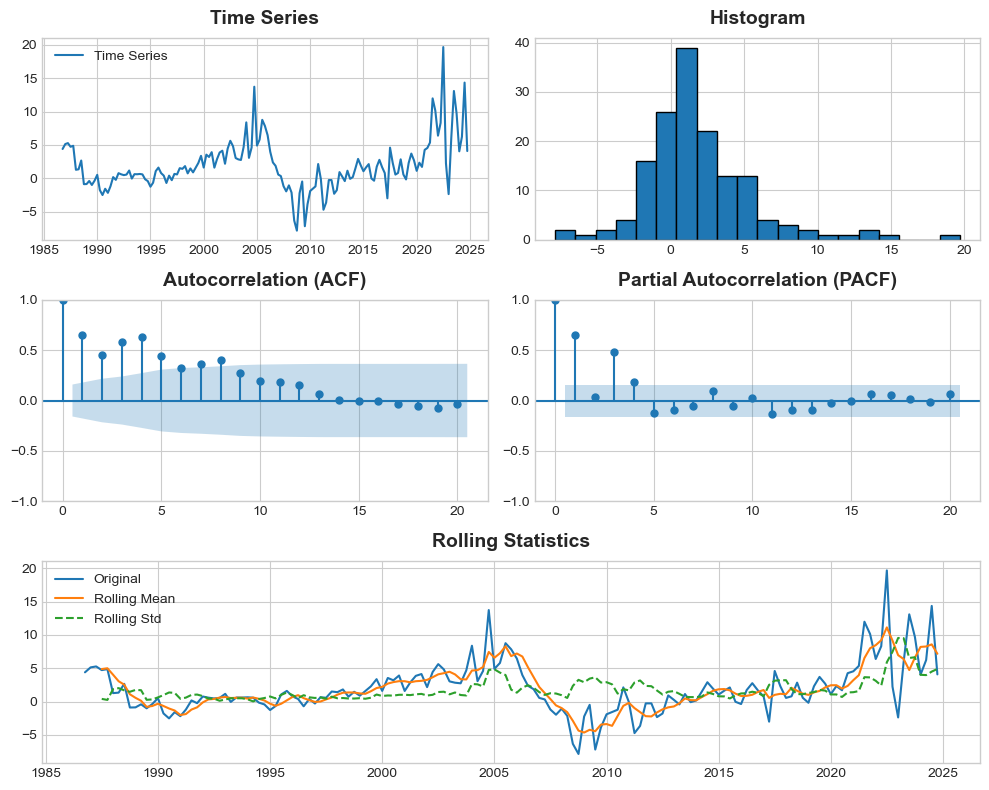

ADF Statistic: -1.7959111969288384
p-value: 0.3824935521034996
Critical Values: {'1%': np.float64(-3.4750180242954167), '5%': np.float64(-2.8811408028842043), '10%': np.float64(-2.577221358046935)}
The series is non-stationary.


In [17]:
#  Check to see if differencing helps transform the series for stationarity.
df_ewr = df.iloc[:, 5]
evaluate_stationarity(df_ewr, window=4, lags=20, transformation='diff')

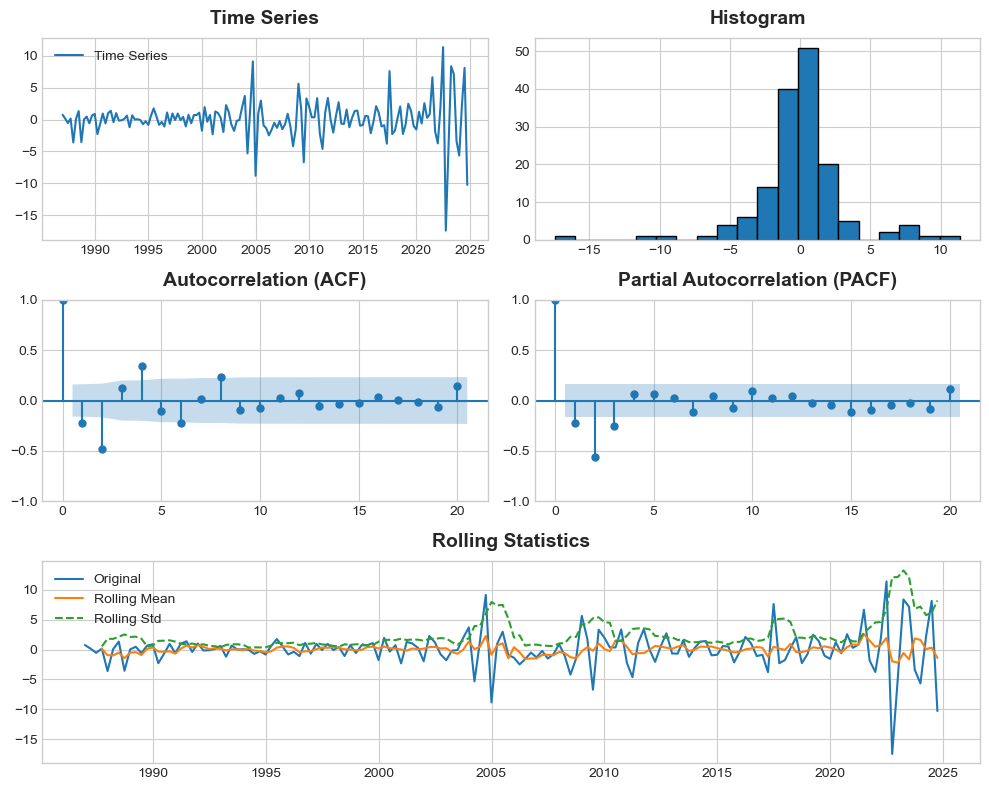

ADF Statistic: -12.792046474649556
p-value: 7.042920093179222e-24
Critical Values: {'1%': np.float64(-3.4750180242954167), '5%': np.float64(-2.8811408028842043), '10%': np.float64(-2.577221358046935)}
The series is stationary.


In [18]:
#  Check to see if differencing_2 helps transform the series for stationarity.
df_ewr = df.iloc[:, 5]
evaluate_stationarity(df_ewr, window=4, lags=20, transformation='diff2')

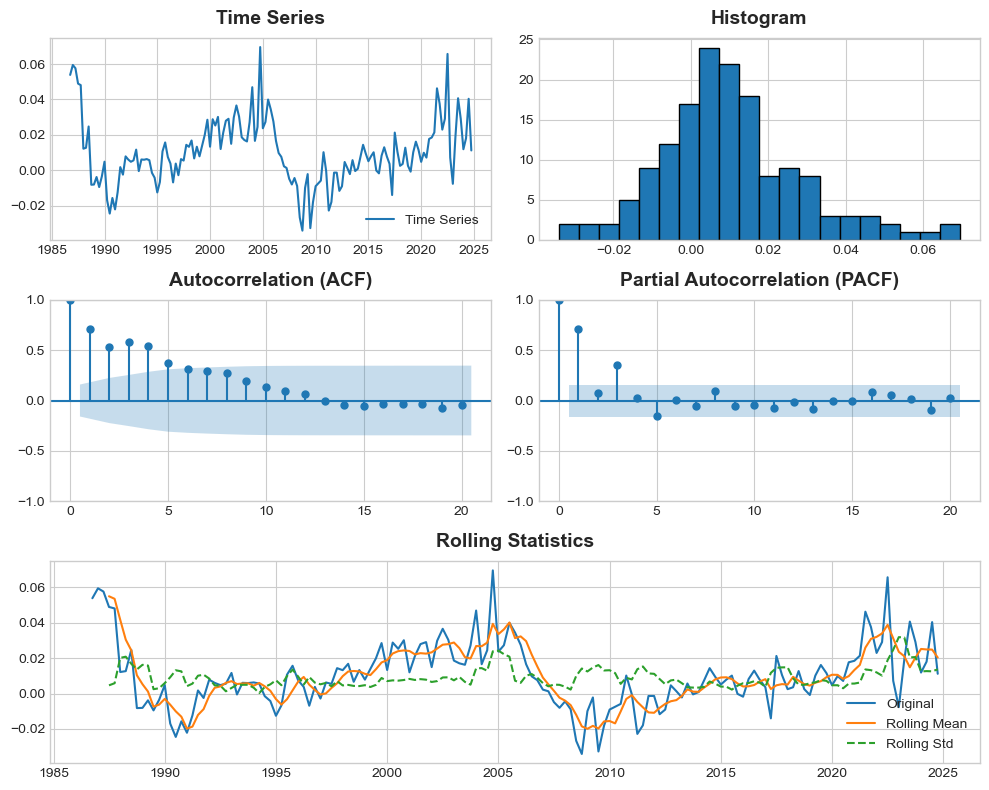

ADF Statistic: -3.27736671777976
p-value: 0.015920997627139735
Critical Values: {'1%': np.float64(-3.4750180242954167), '5%': np.float64(-2.8811408028842043), '10%': np.float64(-2.577221358046935)}
The series is stationary.


In [19]:
#  Check to see if log-differencing helps transform the series for stationarity.
evaluate_stationarity(df_ewr, window=4, lags=20, transformation='log_diff')

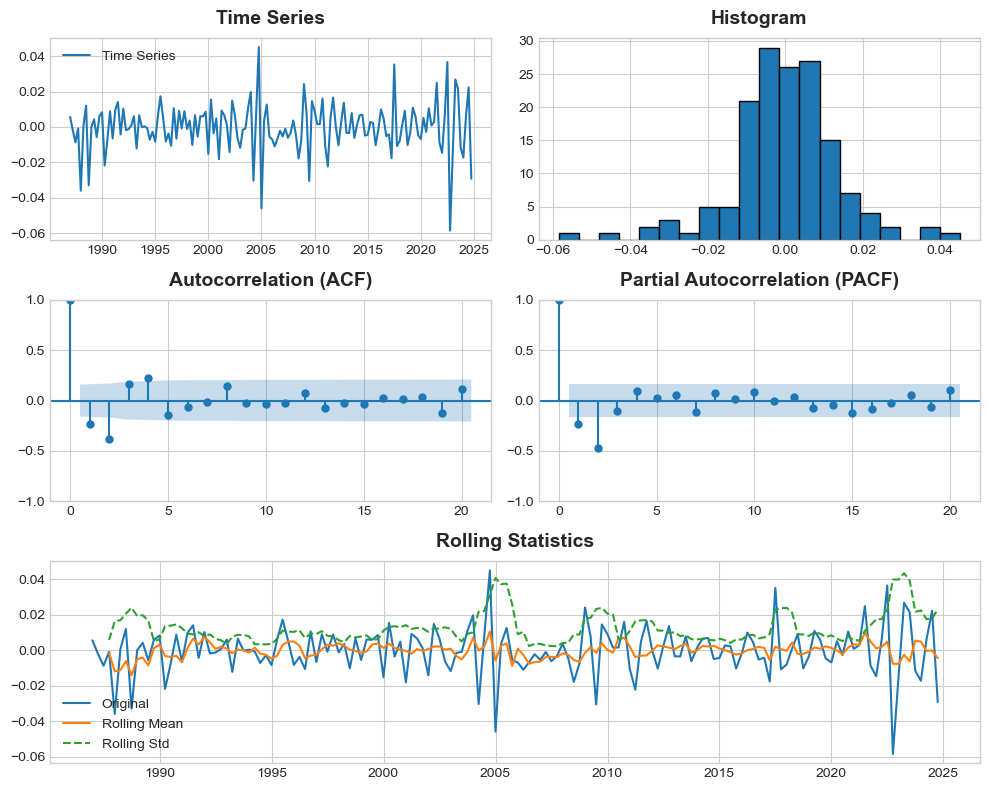

ADF Statistic: -10.550677957470493
p-value: 8.191611888361955e-19
Critical Values: {'1%': np.float64(-3.4750180242954167), '5%': np.float64(-2.8811408028842043), '10%': np.float64(-2.577221358046935)}
The series is stationary.


In [20]:
#  Check to see if log-differencing helps transform the series for stationarity.
evaluate_stationarity(df_ewr, window=4, lags=20, transformation='log_diff2')

####  Observations
-  The raw series data is not stationary.
-  Difference transforming the series did not improve the series stationarity.
-  2nd order differencing of the series improved the stationarity but it still seems like the series showed heteroskedasticity (changing variance)
-  Log-Difference transformation improved the stationarity.  Although, there still appears to be some autocorrelation in the transformed series.
-  Log-Difference(2nd order) improved the stationarity.  There still seems to be some autocorrelation.

## 6. Time Series Decomposition <a class="anchor" id="section-6"></a>

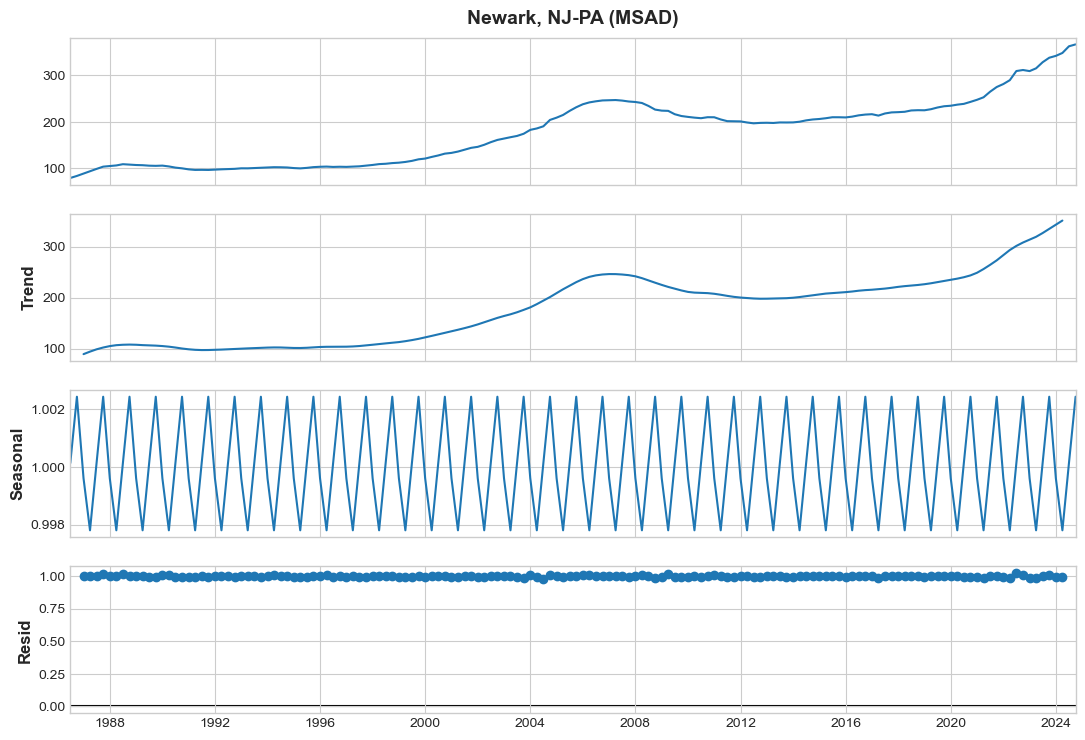

In [21]:
decomposition_plot_multi = seasonal_decompose(df_ewr, model='multiplicative')
# Plot the decomposition directly, using the created axes
fig = decomposition_plot_multi.plot()
fig.set_size_inches((12, 8))
plt.show()

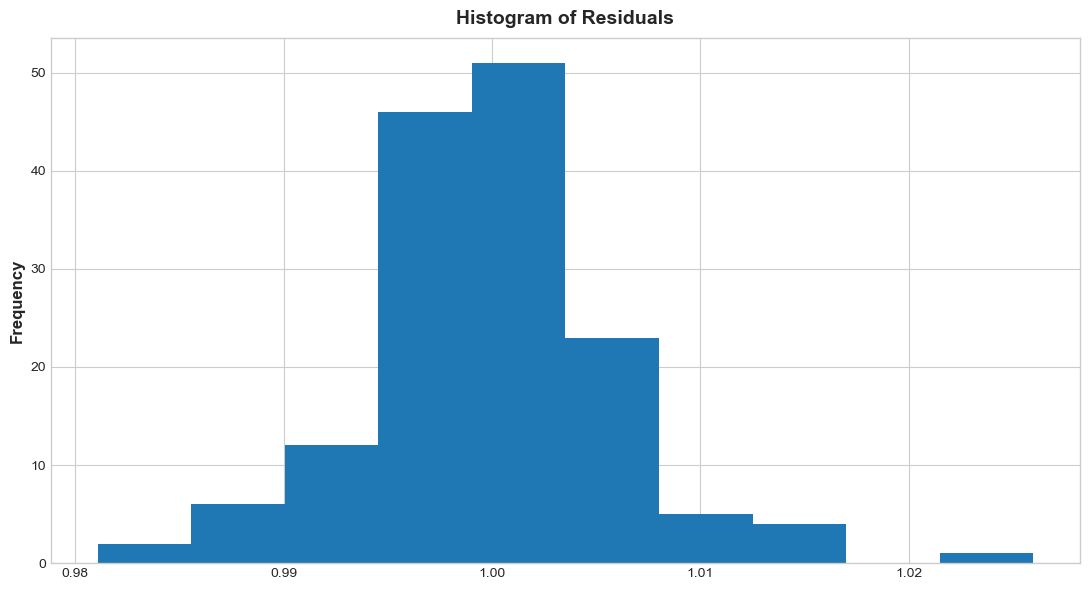

In [22]:
fig = decomposition_plot_multi.resid.plot(kind='hist', bins=10, figsize=(11,6))
plt.title('Histogram of Residuals')
plt.show()

####  Observations:
-  It appears that most of the series can be defined by trend.  The trend is not constant and not linear.
-  There is a seasonal component which is every 2 periods (quarters) although it is very small.  This makes sense as there are two sales cycles for homes.
-  The residuals follow an approximate normal distribution.

## 6. Modeling and Evaluation <a class="anchor" id="section-6"></a>

In [23]:
#  score the predictions vs. test data
def rmse(observations, estimates):
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    mean_sq_diff = np.mean(difference ** 2)
    rmse = np.sqrt(mean_sq_diff)
    
    return rmse

def mape(observations, estimates):
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    mape = np.mean(np.abs(difference/observations))*100
    
    return mape

In [24]:
period_forecast = 12
train = df_ewr[:-period_forecast]
test = df_ewr[-period_forecast:]

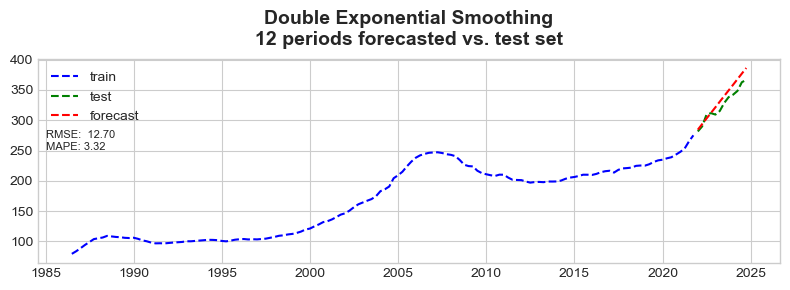

In [25]:
#  Try Double Exponential Smoothing Forecast
#  Double Exponential Smoothing
fig = plt.figure(figsize=(8,3))
double = Holt(train.values).fit(optimized=True)
double_preds = double.forecast(len(test.values))
plt.plot(train.index, train.values, 'b--', label='train')
plt.plot(test.index, test.values, 'g--', label='test')
plt.plot(test.index, double_preds, 'r--', label='forecast')
plt.title(f'Double Exponential Smoothing\n{period_forecast} periods forecasted vs. test set')
plt.legend(loc='upper left')
plt.annotate(f'RMSE:  {rmse(test.values, double_preds):.02f} \nMAPE: {mape(test.values, double_preds):.2f}',xy=(0.01, 0.65), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=8)
plt.show()

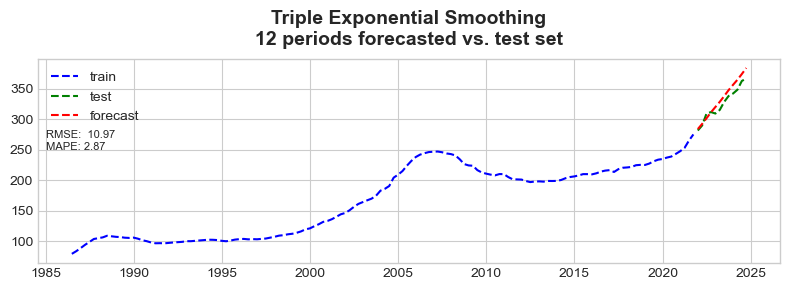

In [26]:
#  Triple Exponential Smoothing
fig = plt.figure(figsize=(8,3))
triple = ExponentialSmoothing(train.values,
                              trend="additive",
                              seasonal="multiplicative",
                              seasonal_periods=4).fit(optimized=True)
triple_preds = triple.forecast(len(test.values))
plt.plot(train.index, train.values, 'b--', label='train')
plt.plot(test.index, test.values, 'g--', label='test')
plt.plot(test.index, triple_preds, 'r--', label='forecast')
plt.title(f'Triple Exponential Smoothing\n{period_forecast} periods forecasted vs. test set')
plt.legend(loc='upper left')
plt.annotate(f'RMSE:  {rmse(test.values, triple_preds):.02f}\nMAPE: {mape(test.values, triple_preds):.2f}',xy=(0.01, 0.65), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=8)
plt.show()

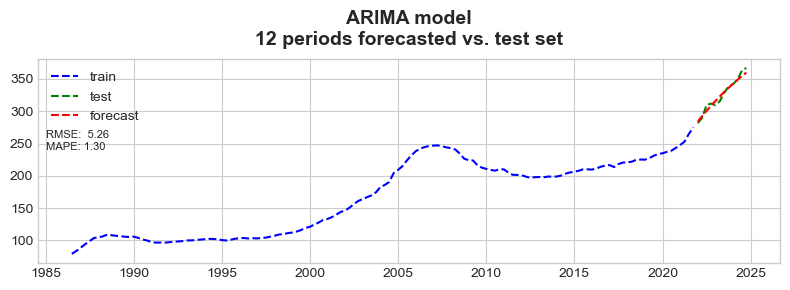

In [27]:
#  ARIMA Model

model = ARIMA(train, order=(1, 1, 1), trend=None).fit()
arima_preds = model.forecast(len(test.values))

fig = plt.figure(figsize=(8,3))
plt.plot(train.index, train.values, 'b--', label='train')
plt.plot(test.index, test.values, 'g--', label='test')
plt.plot(test.index, arima_preds, 'r--', label='forecast')
plt.title(f'ARIMA model\n{period_forecast} periods forecasted vs. test set')
plt.legend(loc='upper left')
plt.annotate(f'RMSE:  {rmse(test.values, arima_preds.values):.02f}\nMAPE: {mape(test.values, arima_preds.values):.2f}',xy=(0.01, 0.65), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=8)
plt.show()

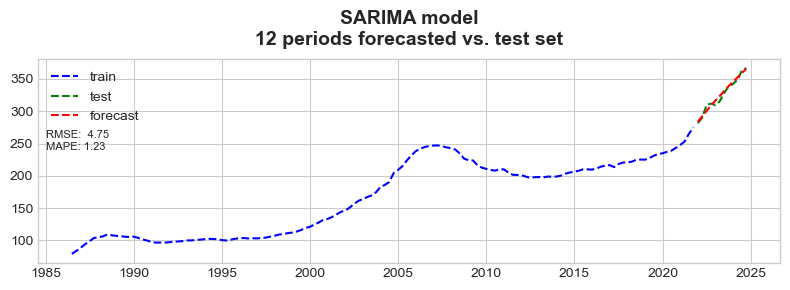

In [28]:
# SARIMA Model
sar = sm.tsa.statespace.SARIMAX(train.values, order=(1,1,1), seasonal_order=(0,1,1,4), trend=None).fit()
sarima_preds = sar.forecast(len(test.values))
# plot train, test and forecast
fig = plt.figure(figsize=(8,3))
plt.plot(train.index, train.values, 'b--', label='train')
plt.plot(test.index, test.values, 'g--', label='test')
plt.plot(test.index, sarima_preds, 'r--', label='forecast')
plt.title(f'SARIMA model\n{period_forecast} periods forecasted vs. test set')
plt.legend(loc='upper left')
plt.annotate(f'RMSE:  {rmse(test.values, sarima_preds):.02f}\nMAPE: {mape(test.values, sarima_preds):.2f}',xy=(0.01, 0.65), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=8)
plt.show()

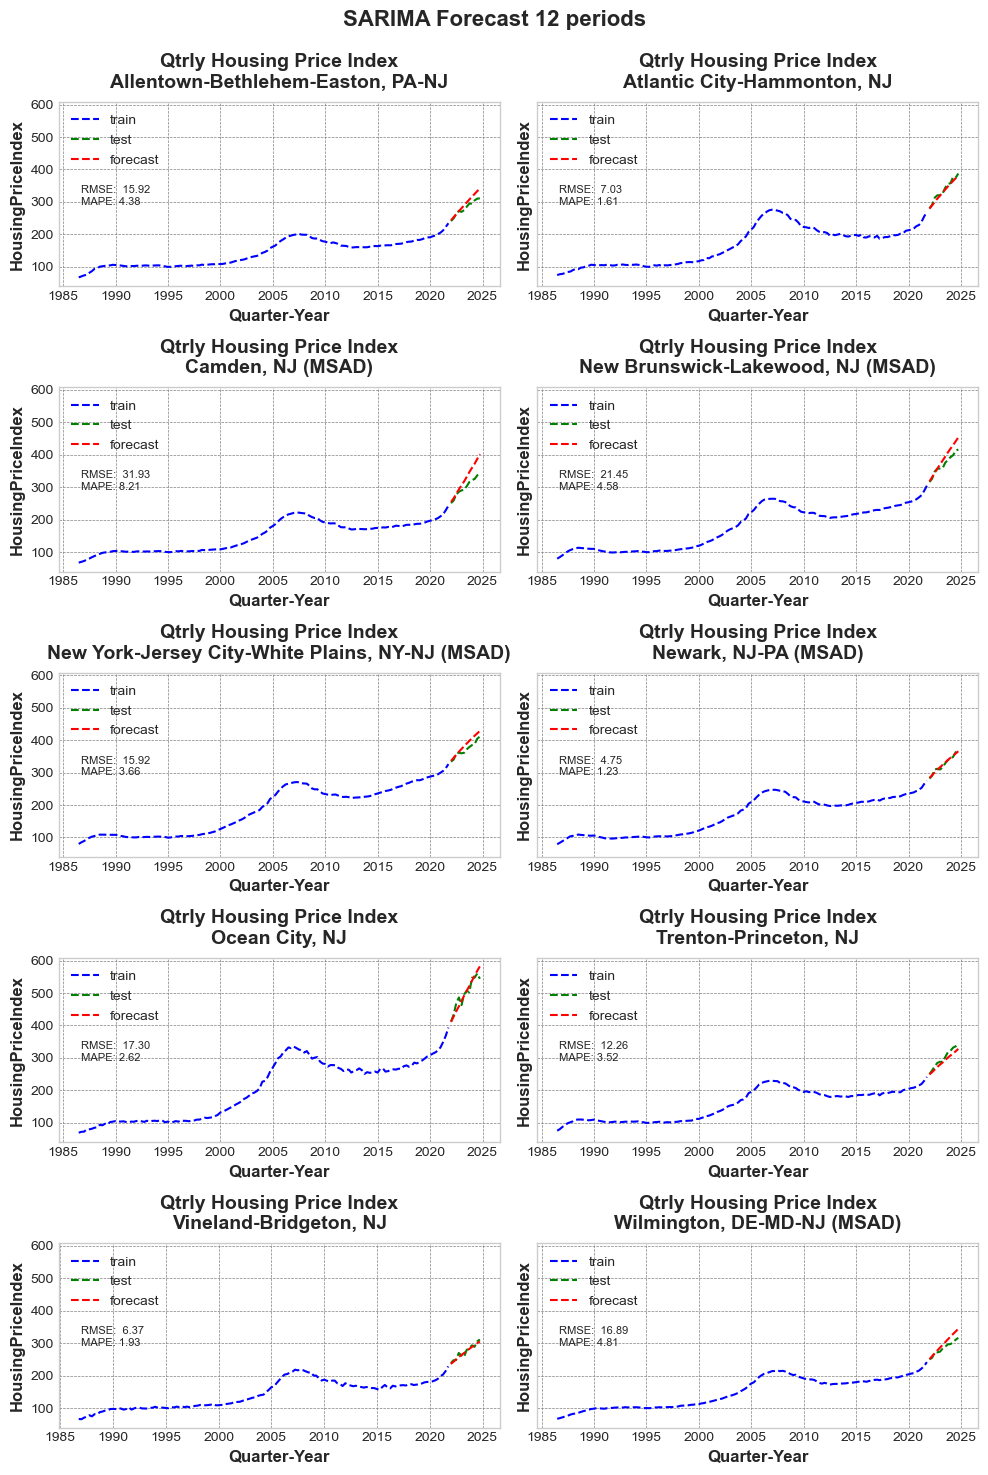

In [29]:
fig, axs = plt.subplots(5, 2, figsize=(10, 15), sharey=True)
axs = axs.flatten()
period_forecast = 12
for i, col in enumerate(df.columns):

    train = df[col][:-period_forecast]
    test = df[col][-period_forecast:]
    # SARIMA Model
    sar = sm.tsa.statespace.SARIMAX(train.values, order=(1,1,1), seasonal_order=(0,1,1,4), trend=None).fit()
    sarima_preds = sar.forecast(len(test.values))
    # model = ARIMA(train, order=(1, 1, 1), trend=None).fit()
    # arima_preds = model.forecast(len(test.values))
   # plot train, test and forecast
    axs[i].plot(train.index, train.values, 'b--', label='train')
    axs[i].plot(test.index, test.values, 'g--', label='test')
    axs[i].plot(test.index, sarima_preds, 'r--', label='forecast')
    axs[i].set_title(f'ARIMA model\n{period_forecast} periods forecasted vs. test set')
    axs[i].legend(loc='upper left')
    axs[i].annotate(f'RMSE:  {rmse(test.values, sarima_preds):.02f}\nMAPE: {mape(test.values, sarima_preds):.2f}',xy=(0.05, 0.55), xycoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=8)

    axs[i].set_title(f'Qtrly Housing Price Index\n{col}')
    axs[i].grid(True, which="major", linestyle="--", linewidth=0.5, color="gray")
    axs[i].set_ylabel('HousingPriceIndex')
    axs[i].set_xlabel('Quarter-Year')
plt.suptitle(f'SARIMA Forecast {period_forecast} periods\n', fontsize=16, fontweight='bold' )
plt.tight_layout()
plt.show()

In [30]:
train = df.iloc[:, 5]
# SARIMA Model
sar = sm.tsa.statespace.SARIMAX(train.values, order=(1,1,1), seasonal_order=(0,1,1,4), trend=None).fit()
sarima_preds = sar.forecast(period_forecast)
forecast_index = pd.date_range(start=train.index.max(), periods=13, freq='QE')[1:]


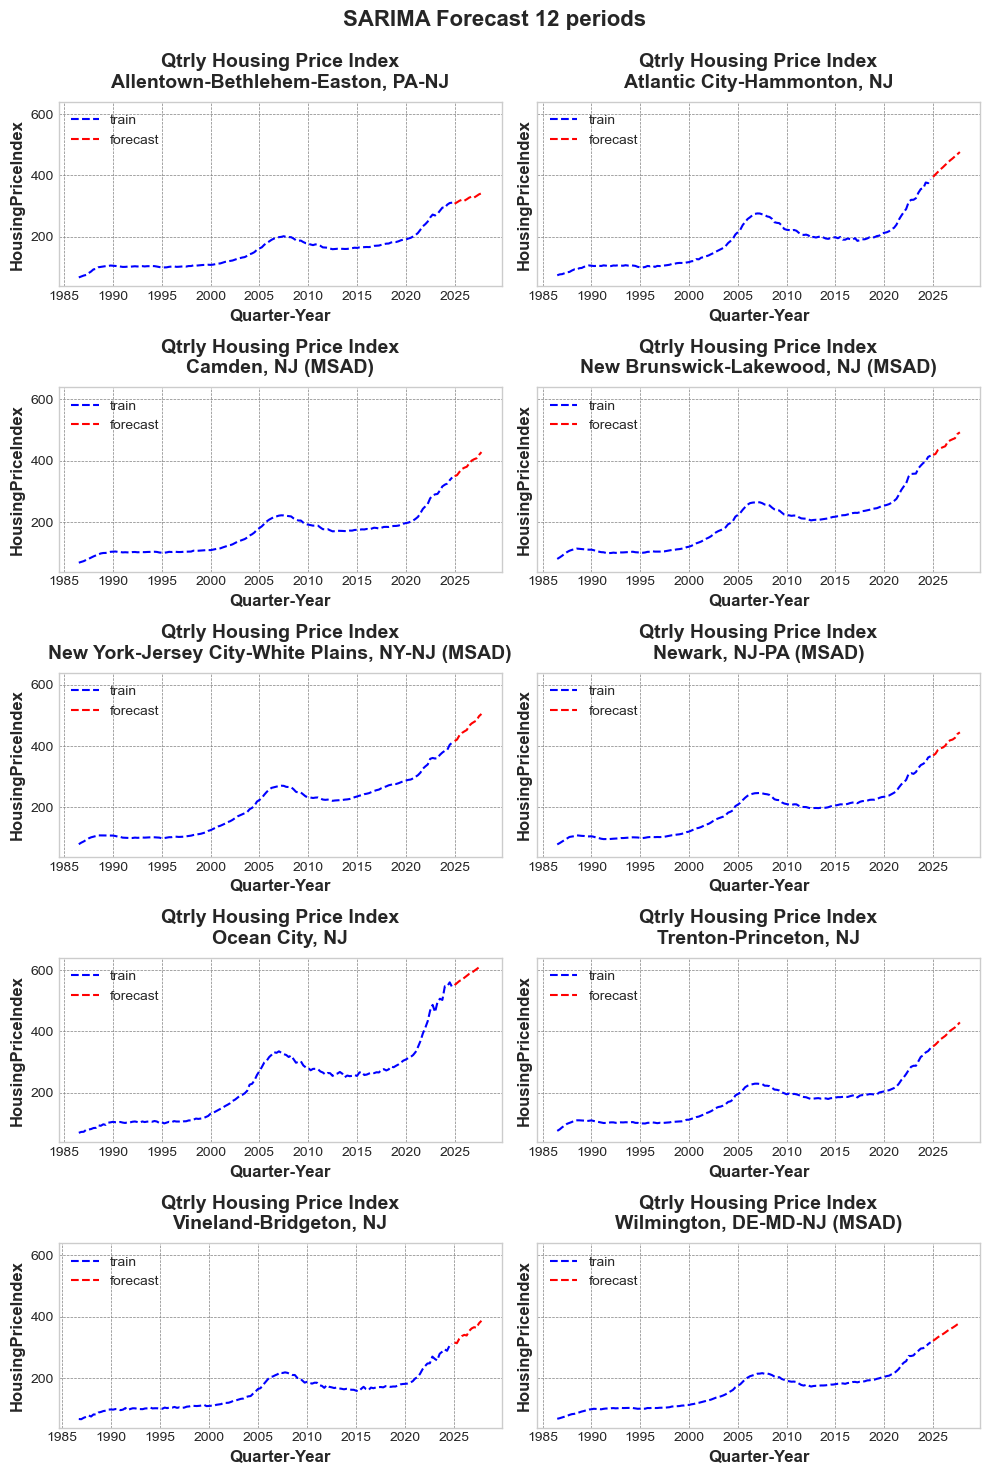

In [31]:
#  Forecast into the future using entire training set.
fig, axs = plt.subplots(5, 2, figsize=(10, 15), sharey=True)
axs = axs.flatten()
period_forecast = 12
for i, col in enumerate(df.columns):
    
    train = df[col]
    forecast_index = pd.date_range(start=train.index.max(), periods=13, freq='QE')[1:]
    # SARIMA Model
    sar = sm.tsa.statespace.SARIMAX(train.values, order=(1,1,1), seasonal_order=(0,1,1,4), trend=None).fit()
    sarima_preds = sar.forecast(period_forecast)
    df_sarima_preds = pd.DataFrame(sarima_preds, index=forecast_index)
    # model = ARIMA(train, order=(1, 1, 1), trend=None).fit()
    # arima_preds = model.forecast(len(test.values))
   # plot train, test and forecast
    axs[i].plot(train.index, train.values, 'b--', label='train')
    axs[i].plot(df_sarima_preds.index, df_sarima_preds.values, 'r--', label='forecast')
    axs[i].set_title(f'ARIMA model\n{period_forecast} periods forecasted vs. test set')
    axs[i].legend(loc='upper left')

    axs[i].set_title(f'Qtrly Housing Price Index\n{col}')
    axs[i].grid(True, which="major", linestyle="--", linewidth=0.5, color="gray")
    axs[i].set_ylabel('HousingPriceIndex')
    axs[i].set_xlabel('Quarter-Year')
plt.suptitle(f'SARIMA Forecast {period_forecast} periods\n', fontsize=16, fontweight='bold' )
plt.tight_layout()
plt.show()

## 7. Findings and Conclusions <a class="anchor" id="section-7"></a>

#### Observations, and Thoughts on Future Work, Next Steps:
-  It appears the 12 quarter forecast is fairly accurate with the Mean Absolute Percentage Error (MAPE) being under 4% for most markets and in some cases below 2%.
-  The 12 quarter forecast shows that the forecast has a MAPE > 4% and is overpredicting the HPI for markets in Camden, New Brunswick, Allentown-Bethlehem-Easton and Wilmington, DE metro.  NY-NJ-WhitePlains is also overpredicting but by a smaller margin (3.6%)
-  Only the princeton-trenton market outperformed the forecast with higher actuals.
-  What could this suggest?
    -  Could these areas which are underperforming their predictions be leading a downturn?
    -  The forecast which is reliant on past data is predicting better performance than is actually being achieved.  This could indicate a slowdown in the market in these regions.
    -  There is only 1 market (Princeton-Trenton metro) which the forecast marginally underpredicts the actual index.
    -  As a sensitivity, I ran the above forecast with a 4 period forecast and a 8 period forecast.  The 4 period forecast was, as expected, more accurate than the 12 period forecast.  Surprisingly, the 8 period forecast resulted in a less accurate forecast which overpredicted the HPIs more than the 12 period forecast.  This suggests that the data in the 8 period is influencing the over-forecasted HPI's.
    -  Could this suggest the housing market is cooling off now?